## Density cross-sections along and across the canyon 

In [1]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import matplotlib.gridspec as gspec
import numpy as np
import seaborn as sns
import scipy.stats
import pandas as pd
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

import os
import sys
import warnings
warnings.filterwarnings("ignore")

/home/kramosmu/anaconda3/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density using a linear equation of state.
    
    INPUT:
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be at least 2D array in coordinate order (..., Y , X ) 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [...,ny,nx]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T[...,:,:]) + beta*(S[...,:,:]))
    return rho



def call_rho(t,yslice,xslice, state):
    T = state.Temp.isel(T=t,Y=yslice,X=xslice)
    S = state.S.isel(T=t,Y=yslice,X=xslice)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 


In [12]:
def plot_rho_trac(state, ptracer, title):
    sns.set_style('dark')
    sns.set_context('talk')
    plt.rcParams['font.size'] = 14.0
    f = plt.figure(figsize = (10,8)) # 190mm = 7.48 in, 115mm = 4.5in

    gs = gspec.GridSpec(2, 1, width_ratios=[1],height_ratios=[1,0.7],wspace=0.2)
    gs0 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0],hspace=0.1)
    gs1 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1],hspace=0.1)

    ax0 = plt.subplot(gs0[0])
    ax1 = plt.subplot(gs0[1])
    ax2 = plt.subplot(gs1[0])

    t=4 # days

    #%%%%%%%%%%%%% Contours density Alongshelf %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    tslice = slice(6,8)
    yslice = 245
    xslice = slice(120,240)

    # - - - - Tracer - - - - - - 
    Tr_min = 0
    Tr_max = 17 
    csU = np.linspace(Tr_min,Tr_max,num=30)

    mesh = ax0.contourf(grid.X[xslice]/1000,grid.Z[:48],
                        np.ma.array(np.nanmean(ptracers.Tr1[tslice,:48,yslice,xslice].data,axis=0),
                                    mask=MaskC[:48,yslice,xslice]),
                        csU,cmap=cmo.cm.delta)

    # - - - - density - - - - - - 
    rho_min = 1020.7-1000.0
    rho_max = 1021.7-1000.0 # 1022.4 if y=230,1021.4 if y=260
    csU2 = np.linspace(rho_min,rho_max,num=21)

    density = call_rho(tslice,yslice,xslice, state)

    CS2 = ax0.contour(grid.X[xslice]/1000,grid.Z[:48],
                      np.ma.array(np.nanmean(density[:,:48,:].data-1000,axis=0),
                                  mask=MaskC[:48,yslice,xslice]),
                      csU2,colors='k',linewidths=[0.75] )
    plt.clabel(CS2,csU2[::4],inline=True, fmt='%.1f',fontsize=10)

    # - - - - extras - - - - - - - 
    ax2.text(1.05,-0.1,'($\mu$M)',transform=ax2.transAxes)
    ax0.set_ylabel('Depth (m)',labelpad=0.0)
    ax0.set_xlabel('Alongshelf distance (km)',labelpad=0.0)
    ax0.tick_params(axis='x', pad=1)
    ax0.tick_params(axis='y', pad=1)
    ax0.axvline(grid.X[200]/1000,linestyle='--',color='0.5')
    ax0.plot(grid.X[xslice]/1000,-grid.Depth[267,xslice],':',color='0.5',linewidth=3)
    ax0.axhline(-grid.Depth[226,100],linestyle=':',color='0.5',linewidth=3)
    ax0.set_title(title)
    #%%%%%%%%%%%%% Contours density cross-shore %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    yslice = slice(220,270)
    xslice = 200

    # - - - - - tracer - - - - - 
    mesh=ax1.contourf(grid.Y[yslice]/1000,grid.Z[:48],
                     np.ma.array(np.nanmean(ptracers.Tr1[tslice,:48,yslice,xslice].data,axis=0),
                                 mask=MaskC[:48,yslice,xslice]),
                     csU,cmap=cmo.cm.delta)
    cbar_ax = f.add_axes([0.91, 0.48, 0.02, 0.4])
    cb=f.colorbar(mesh, cax=cbar_ax,ticks=[0,2,4,6,8,10,12,14,16],format='%d')
    cb.ax.yaxis.set_tick_params(pad=1)

    # - - - - - density - - - - -
    density = call_rho(tslice,yslice,xslice, state)

    CS3 = ax1.contour(grid.Y[yslice]/1000,grid.Z[:48],
                    np.ma.array(np.nanmean(density[:,:48,:].data-1000,axis=0),mask=MaskC[:48,yslice,xslice]),
                    levels=csU2,colors='k',linewidths=[0.75] )
    plt.clabel(CS3,csU2[::4],inline=True, fmt='%.1f',fontsize=10)

    # - - - - - extras - - - - --
    ax1.axvline(grid.Y[245]/1000,linestyle='--',color='red')
    ax1.axvline(grid.Y[261]/1000,linestyle='--',color='purple')
    ax1.axvline(grid.Y[267]/1000,linestyle='--',color='blue')
    ax1.axhline(grid.Z[25],linestyle='--',color='purple')
    ax1.axhline(grid.Z[20],linestyle='--',color='purple')
    ax1.plot(grid.Y[yslice]/1000,-grid.Depth[yslice,100],':',color='0.5',linewidth=3)
    ax1.set_xlabel('CS distance (km)',labelpad=0.0)
    ax1.tick_params(axis='x', pad=1)
    ax1.tick_params(axis='y', pad=1)

    #%%%%%%%%%%%%% Contours density rim depth %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    yslice = slice(215,270)
    xslice = slice(110,250)
    # - - - - - tracer - - - - - 
    Tr_min = 0
    Tr_max = 17 
    csU = np.linspace(Tr_min,Tr_max,num=30)
    mesh=ax2.contourf(grid.X[xslice]/1000,grid.Y[yslice]/1000,
                     np.ma.array(np.nanmean(ptracers.Tr1[tslice,26,yslice,xslice].data,axis=0),
                                 mask=MaskC[26,yslice,xslice]),
                     csU,cmap=cmo.cm.delta)
    cbar_ax = f.add_axes([0.78, 0.12, 0.02, 0.29])
    cb=f.colorbar(mesh, cax=cbar_ax,ticks=[0,2,4,6,8,10,12,14,16],format='%d')
    cb.ax.yaxis.set_tick_params(pad=1)

    # - - - - - density - - - - -
    rho_min = 1021.0-1000.0
    rho_max = 1021.3-1000.0 # 1022.4 if y=230,1021.4 if y=260
    csU2 = np.linspace(rho_min,rho_max,num=6)

    density = call_rho(tslice,yslice,xslice, state)

    CS4 = ax2.contour(grid.X[xslice]/1000,grid.Y[yslice]/1000,
                     np.ma.array(np.nanmean(density[:,26,:,:].data-1000,axis=0),mask=MaskC[26,yslice,xslice]),
                     levels=csU2,colors='k',linewidths=[0.75] )
    plt.clabel(CS4,csU2,inline=True, fmt='%.2f',fontsize=10)

    # - - - - - extras - - - - --
    ax2.contour(grid.X[xslice]/1000,grid.Y[yslice]/1000,-grid.Depth[yslice,xslice],levels=[-147.5],
                linestyle='--',color='0.5')
    ax2.plot(grid.X[200]/1000, grid.Y[245]/1000,'^',color='red', alpha=0.5)
    ax2.plot(grid.X[200]/1000, grid.Y[261]/1000,'^',color='purple', alpha=0.5)
    ax2.plot(grid.X[200]/1000, grid.Y[267]/1000,'^',color='blue', alpha=0.5)
    
    ax2.set_xlabel('CS distance (km)',labelpad=0.0)
    ax2.tick_params(axis='x', pad=1)
    ax2.tick_params(axis='y', pad=1)

    ax2.set_aspect(1)
    
    plt.show()

In [9]:
grid_file1 = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
state_file2 = '/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run01/stateGlob.nc'

with Dataset(grid_file1, 'r') as nbl:
    Z1 = nbl.variables['RC'][:]
    hfac = nbl.variables['HFacC'][:,:,:]
with Dataset(state_file2,'r') as stfl:
    time = stfl.variables['T'][:]
    
nx = 616
ny = 360
nz = 90

#RhoRef = np.squeeze(rdmds('/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/RhoRef'))
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [10]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run01/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run01/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run01/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)

hFacmasked = np.ma.masked_values(grid.HFacC.data, 0)
MaskC = np.ma.getmask(hFacmasked)


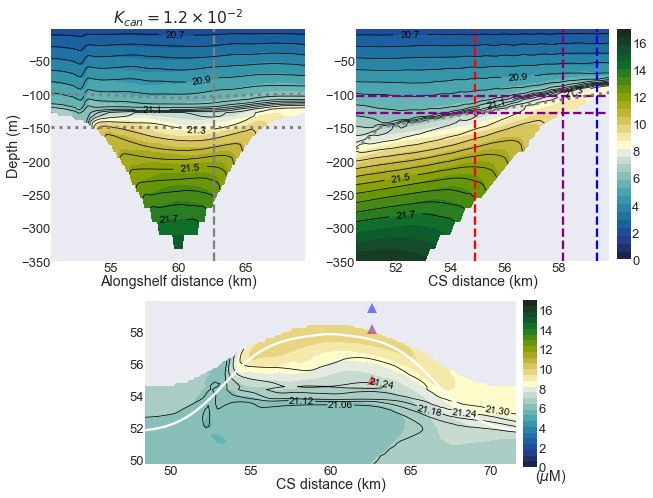

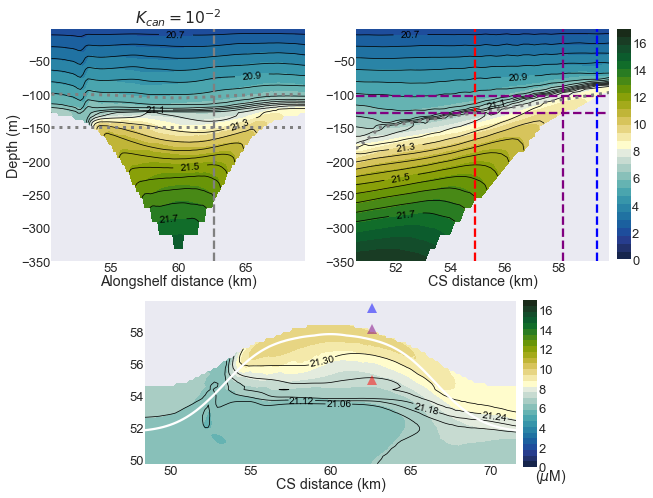

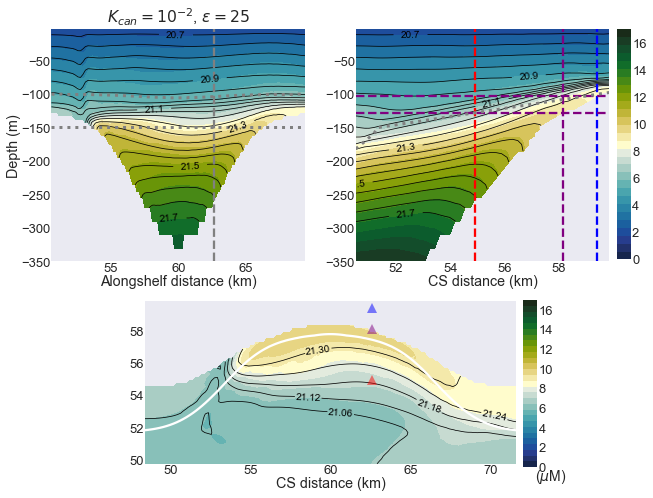

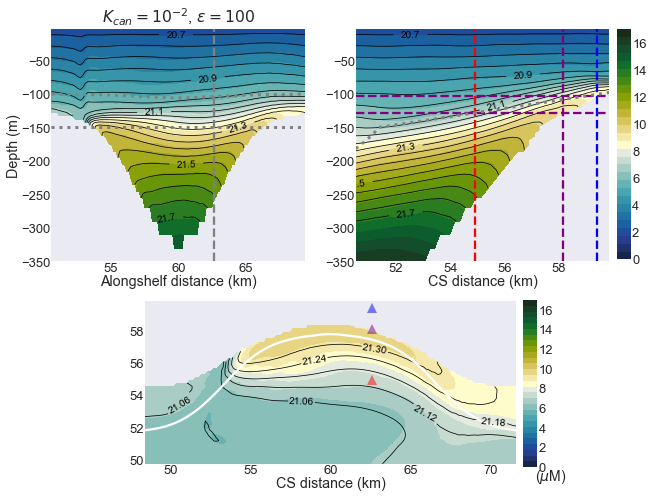

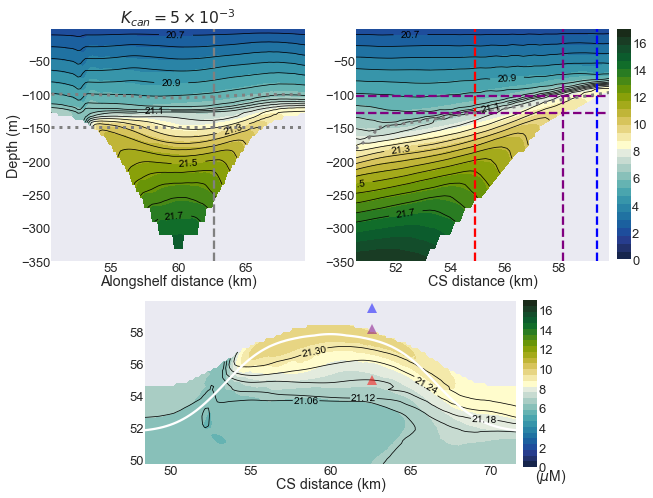

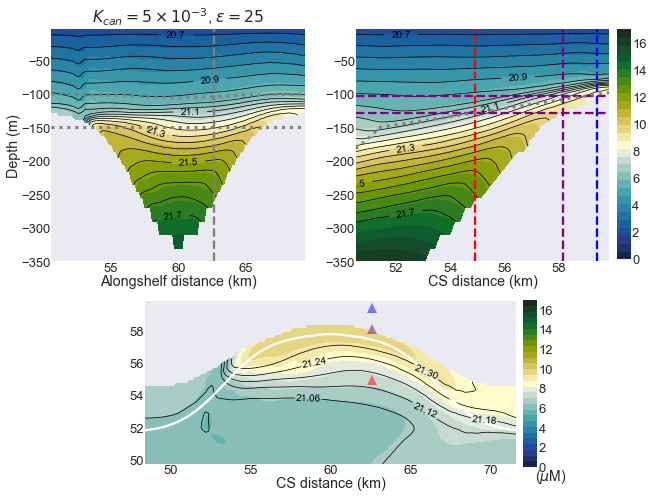

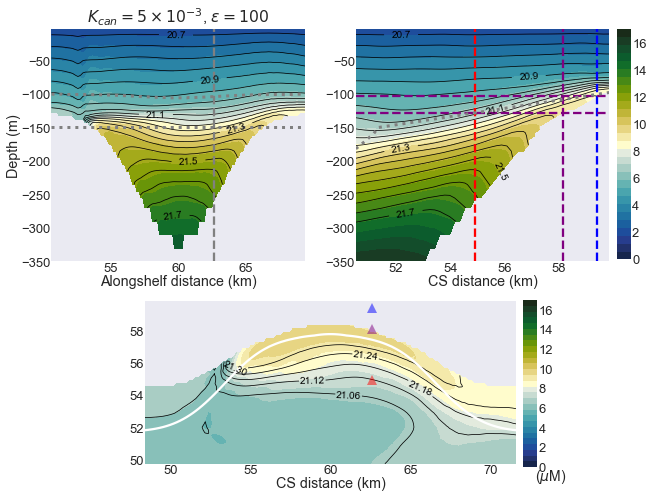

In [13]:
runs = ['run24', 'run27', 'run08','run10', 'run17', 'run21', 'run22']
labels = [r'$K_{can}=1.2\times10^{-2}$',r'$K_{can}=10^{-2}$',r'$K_{can}=10^{-2}$, $\epsilon=25$',
          r'$K_{can}=10^{-2}$, $\epsilon=100$',r'$K_{can}=5\times10^{-3}$',r'$K_{can}=5\times10^{-3}$, $\epsilon=25$',
          r'$K_{can}=5\times10^{-3}$, $\epsilon=100$'
         ]
for run,lab in zip(runs, labels):
    sfile = ('/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/%s/stateGlob.nc' %run)
    pfile = ('/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/%s/ptracersGlob.nc' %run)
    
    st = xr.open_dataset(sfile)
    ptr = xr.open_dataset(pfile)
    
    plot_rho_trac(st, ptr, lab)